In [34]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

pd.set_option("display.max_columns", 200)
np.random.seed(42)
DATA_PATH = "../data/processed/bank_marketing_raw.csv" 

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(45211, 21)


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y,poutcome_missing,target,pdays_contacted,has_previous_campaign
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,no_previous_campaign,no,1,0,1,0
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,no_previous_campaign,no,1,0,1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,no_previous_campaign,no,1,0,1,0
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,no_previous_campaign,no,1,0,1,0
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,no_previous_campaign,no,1,0,1,0


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    45211 non-null  int64 
 1   job                    44923 non-null  object
 2   marital                45211 non-null  object
 3   education              43354 non-null  object
 4   default                45211 non-null  object
 5   balance                45211 non-null  int64 
 6   housing                45211 non-null  object
 7   loan                   45211 non-null  object
 8   contact                32191 non-null  object
 9   day_of_week            45211 non-null  int64 
 10  month                  45211 non-null  object
 11  duration               45211 non-null  int64 
 12  campaign               45211 non-null  int64 
 13  pdays                  45211 non-null  int64 
 14  previous               45211 non-null  int64 
 15  poutcome           

In [36]:
df["pdays_contacted"] = (~df["pdays"].isin([-1, 999])).astype(int)

In [37]:
df['pdays_contacted'].value_counts()

pdays_contacted
0    36954
1     8257
Name: count, dtype: int64

In [38]:
# Assume df already exists in memory
print(df.shape)
print(df.dtypes.value_counts())

# Ensure target exists and is binary 0/1
assert "target" in df.columns, "Missing 'target' column"
print(df["target"].value_counts(dropna=False).head())
print("Overall conversion (target=1):", df["target"].mean())

# Optional: check original y
if "y" in df.columns:
    print(df["y"].value_counts(dropna=False).head())


(45211, 21)
int64     11
object    10
Name: count, dtype: int64
target
0    39922
1     5289
Name: count, dtype: int64
Overall conversion (target=1): 0.11698480458295547
y
no     39922
yes     5289
Name: count, dtype: int64


In [39]:
df["target"].value_counts(dropna=False)
TARGET = "target"

SEGMENT_FEATURES = [
    "age", "balance",
    "job", "marital", "education",
    "default", "housing", "loan",
]
CAMPAIGN_HISTORY = [
    "has_previous_campaign",
    "pdays_contacted",
]

LEAKAGE_FEATURES = [
    "duration", "campaign", "previous", "pdays",
    "contact", "month", "day_of_week",
    "poutcome", "poutcome_missing",
]

SEGMENT_FEATURES = [c for c in SEGMENT_FEATURES if c in df.columns]
CAMPAIGN_HISTORY = [c for c in CAMPAIGN_HISTORY if c in df.columns]
LEAKAGE_FEATURES = [c for c in LEAKAGE_FEATURES if c in df.columns]

print("SEGMENT_FEATURES:", SEGMENT_FEATURES)
print("CAMPAIGN_HISTORY:", CAMPAIGN_HISTORY)
print("LEAKAGE_FEATURES:", LEAKAGE_FEATURES)


SEGMENT_FEATURES: ['age', 'balance', 'job', 'marital', 'education', 'default', 'housing', 'loan']
CAMPAIGN_HISTORY: ['has_previous_campaign', 'pdays_contacted']
LEAKAGE_FEATURES: ['duration', 'campaign', 'previous', 'pdays', 'contact', 'month', 'day_of_week', 'poutcome', 'poutcome_missing']


In [40]:
miss = df[SEGMENT_FEATURES].isna().mean().sort_values(ascending=False)
print(miss[miss > 0])


education    0.041074
job          0.006370
dtype: float64


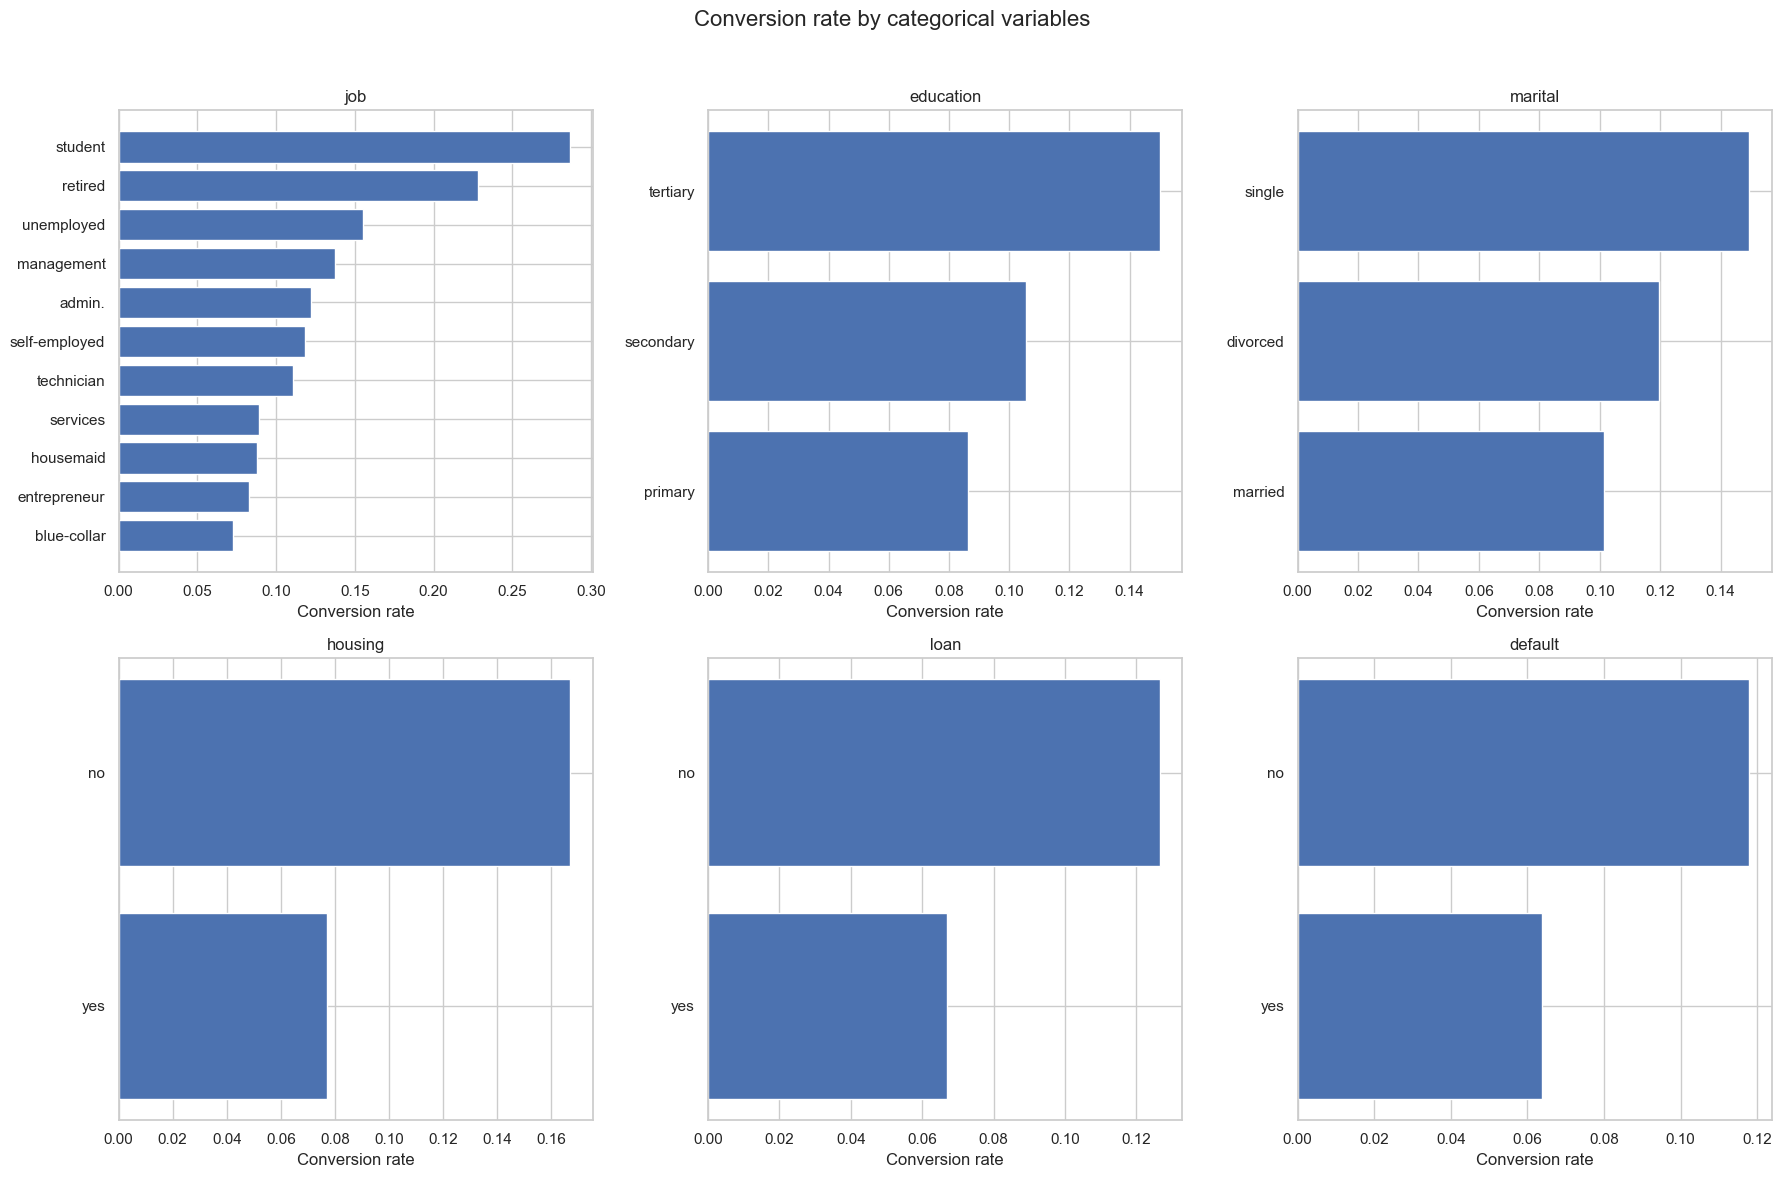

In [41]:
import math


def plot_conversion_by_cat_multi(
    data,
    cols,
    target,
    top_n=12,
    ncols=3,
    figsize=(18, 12),
):
    cols = [c for c in cols if c in data.columns]
    n_plots = len(cols)
    nrows = math.ceil(n_plots / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for ax, col in zip(axes, cols):
        tmp = (
            data.groupby(col)[target]
            .agg(["mean", "count"])
            .sort_values("count", ascending=False)
            .head(top_n)
            .sort_values("mean", ascending=True)
        )

        ax.barh(tmp.index.astype(str), tmp["mean"])
        ax.set_title(f"{col}")
        ax.set_xlabel("Conversion rate")

    # Xoá các subplot dư
    for i in range(len(cols), len(axes)):
        fig.delaxes(axes[i])

    fig.suptitle("Conversion rate by categorical variables", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
cat_cols = ["job", "education", "marital", "housing", "loan", "default"]
plot_conversion_by_cat_multi(df, cat_cols, target=TARGET)

SEGMENTATION

In [42]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

In [43]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y,poutcome_missing,target,pdays_contacted,has_previous_campaign
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,no_previous_campaign,no,1,0,0,0
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,no_previous_campaign,no,1,0,0,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,no_previous_campaign,no,1,0,0,0
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,no_previous_campaign,no,1,0,0,0
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,no_previous_campaign,no,1,0,0,0


In [44]:
X = df[SEGMENT_FEATURES].copy()

y = df[TARGET].copy()

num_features = [c for c in SEGMENT_FEATURES if pd.api.types.is_numeric_dtype(df[c])]
cat_features = [c for c in SEGMENT_FEATURES if c not in num_features]

num_pipe = Pipeline([
    ("scaler", RobustScaler())
])

cat_pipe = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_features),
    ("cat", cat_pipe, cat_features),
], remainder="drop")


pipe_dummy = Pipeline([
    ("prep", preprocess),
    ("clf", DummyClassifier(strategy="most_frequent", random_state=42))
])

pipe_lr = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=5000, class_weight="balanced"))
])

pipe_tree = Pipeline([
    ("prep", preprocess),
    ("clf", DecisionTreeClassifier(
        class_weight="balanced",
        random_state=42,
        max_depth=None
    ))
])

models = {
    "Dummy": pipe_dummy,
    "LogReg": pipe_lr,
    "DecisionTree": pipe_tree
}

In [45]:
def topk_table(y_true, y_score, budgets=(0.05, 0.10, 0.20, 0.30)):
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)
    n = len(y_true)
    base_rate = y_true.mean()
    total_pos = y_true.sum()

    order = np.argsort(-y_score)  # descending score
    rows = []
    for b in budgets:
        k = int(np.ceil(b * n))
        idx = order[:k]
        pos_k = int(y_true[idx].sum())
        precision_k = pos_k / k if k > 0 else 0.0
        recall_k = pos_k / total_pos if total_pos > 0 else 0.0
        lift_k = precision_k / base_rate if base_rate > 0 else np.nan

        rows.append({
            "CALL_BUDGET": f"{int(b*100)}%",
            "k_called": k,
            "Precision@k": precision_k,
            "Recall@k": recall_k,          # capture rate
            "Conversions@k": pos_k,
            "Lift@k": lift_k,
            "Base_rate": base_rate
        })
    return pd.DataFrame(rows)


In [46]:
from sklearn.metrics import precision_recall_fscore_support

def best_f1_threshold(y_true, y_score):
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)

    candidates = np.unique(np.quantile(y_score, np.linspace(0.01, 0.99, 99)))
    best = {"thr": 0.5, "f1": -1, "precision": None, "recall": None}

    for thr in candidates:
        y_pred = (y_score >= thr).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
        if f1 > best["f1"]:
            best = {"thr": float(thr), "f1": float(f1), "precision": float(p), "recall": float(r)}
    return best

def pr_auc_scorer(estimator, X, y):
    p = estimator.predict_proba(X)[:, 1]
    return average_precision_score(y, p)

def roc_auc_scorer(estimator, X, y):
    p = estimator.predict_proba(X)[:, 1]
    return roc_auc_score(y, p)


In [47]:
from sklearn.model_selection import StratifiedKFold, cross_validate


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"roc_auc": roc_auc_scorer, "pr_auc": pr_auc_scorer}

compare_rows = []
for name, est in models.items():
    out = cross_validate(est, X, y, cv=cv, scoring=scoring, return_train_score=False)
    compare_rows.append({
        "model": name,
        "ROC-AUC (mean)": out["test_roc_auc"].mean(),
        "ROC-AUC (std)": out["test_roc_auc"].std(),
        "PR-AUC (mean)": out["test_pr_auc"].mean(),
        "PR-AUC (std)": out["test_pr_auc"].std(),
    })

compare_df = pd.DataFrame(compare_rows).sort_values("PR-AUC (mean)", ascending=False)
display(compare_df)

,model,ROC-AUC (mean),ROC-AUC (std),PR-AUC (mean),PR-AUC (std)
1,LogReg,0.666797,0.009369,0.215873,0.006770
2,DecisionTree,0.622832,0.005243,0.186585,0.003754
0,Dummy,0.500000,0.000000,0.116985,0.000043


In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
pipe_lr.fit(X_train, y_train)
p_test = pipe_lr.predict_proba(X_test)[:, 1]
topk_df = topk_table(y_test, p_test, budgets=(0.05, 0.10, 0.20, 0.30))
display(topk_df)

,CALL_BUDGET,k_called,Precision@k,Recall@k,Conversions@k,Lift@k,Base_rate
0,5%,453,0.295806,0.126654,134,2.528328,0.116997
1,10%,905,0.268508,0.229679,243,2.295010,0.116997
2,20%,1809,0.226092,0.386578,409,1.932465,0.116997
3,30%,2713,0.204202,0.523629,554,1.745367,0.116997


In [49]:
from sklearn.metrics import classification_report, confusion_matrix
thr_05 = 0.5
y_pred_05 = (p_test >= thr_05).astype(int)
cm_05 = confusion_matrix(y_test, y_pred_05)
p05, r05, f105, _ = precision_recall_fscore_support(y_test, y_pred_05, average="binary", zero_division=0)

print("\n=== Threshold = 0.5 ===")
print("Confusion matrix:\n", cm_05)
print(f"Precision={p05:.3f} | Recall={r05:.3f} | F1={f105:.3f}")
print(classification_report(y_test, y_pred_05, digits=3, zero_division=0))

# (b) best F1 threshold
best_thr = best_f1_threshold(y_test, p_test)
thr_best = best_thr["thr"]
y_pred_best = (p_test >= thr_best).astype(int)
cm_best = confusion_matrix(y_test, y_pred_best)

print("\n=== Best-F1 Threshold ===")
print("Best threshold:", thr_best)
print("Confusion matrix:\n", cm_best)
print(classification_report(y_test, y_pred_best, digits=3, zero_division=0))


=== Threshold = 0.5 ===
Confusion matrix:
 [[4964 3021]
 [ 395  663]]
Precision=0.180 | Recall=0.627 | F1=0.280
              precision    recall  f1-score   support

           0      0.926     0.622     0.744      7985
           1      0.180     0.627     0.280      1058

    accuracy                          0.622      9043
   macro avg      0.553     0.624     0.512      9043
weighted avg      0.839     0.622     0.690      9043


=== Best-F1 Threshold ===
Best threshold: 0.5479883149919708
Confusion matrix:
 [[5826 2159]
 [ 504  554]]
              precision    recall  f1-score   support

           0      0.920     0.730     0.814      7985
           1      0.204     0.524     0.294      1058

    accuracy                          0.706      9043
   macro avg      0.562     0.627     0.554      9043
weighted avg      0.837     0.706     0.753      9043



In [50]:
prep = pipe_lr.named_steps["prep"]
clf = pipe_lr.named_steps["clf"]

feature_names = prep.get_feature_names_out()
coefs = clf.coef_.ravel()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

In [51]:
top_pos = coef_df.sort_values("coef", ascending=False).head(15)
top_neg = coef_df.sort_values("coef", ascending=True).head(15)

print("\n=== Top positive coefficients (increase propensity) ===")
display(top_pos[["feature","coef"]])

print("\n=== Top negative coefficients (decrease propensity) ===")
display(top_neg[["feature","coef"]])


=== Top positive coefficients (increase propensity) ===


,feature,coef
7,cat__job_retired,0.647874
10,cat__job_student,0.629363
23,cat__housing_no,0.276371
19,cat__education_tertiary,0.196001
12,cat__job_unemployed,0.177854
21,cat__default_no,0.175094
25,cat__loan_no,0.167459
16,cat__marital_single,0.140899
2,cat__job_admin.,0.095873
1,num__balance,0.048083



=== Top negative coefficients (decrease propensity) ===


,feature,coef
24,cat__housing_yes,-0.419072
5,cat__job_housemaid,-0.394924
22,cat__default_yes,-0.317795
26,cat__loan_yes,-0.310159
4,cat__job_entrepreneur,-0.298563
17,cat__education_primary,-0.279158
13,cat__job_nan,-0.256557
15,cat__marital_married,-0.237845
3,cat__job_blue-collar,-0.220785
8,cat__job_self-employed,-0.188476


In [52]:
X = df[SEGMENT_FEATURES].copy() 
y = df[TARGET].astype(int).copy()

num_features = [c for c in SEGMENT_FEATURES if pd.api.types.is_numeric_dtype(df[c])]
cat_features = [c for c in SEGMENT_FEATURES if c not in num_features]

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_features),
    ("cat", cat_pipe, cat_features),
])

model = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",
)

pipe = Pipeline([
    ("prep", preprocess),
    ("clf", model)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)
p_test = pipe.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, p_test))
print("PR-AUC :", average_precision_score(y_test, p_test))


ROC-AUC: 0.6663001753050676
PR-AUC : 0.21135831169442787


In [53]:
def precision_at_k(y_true, p, k_frac=0.2):
    y_true = pd.Series(y_true).reset_index(drop=True)
    p = np.asarray(p)
    n = len(p)
    k = max(1, int(n * k_frac))
    idx = np.argsort(-p)[:k]
    return float(y_true.iloc[idx].mean())

def lift_at_k(y_true, p, k_frac=0.2):
    base = float(pd.Series(y_true).mean())
    prec = precision_at_k(y_true, p, k_frac)
    return prec / base if base > 0 else np.nan

for k in [0.05, 0.10, 0.20, 0.30]:
    prec = precision_at_k(y_test, p_test, k)
    lift = lift_at_k(y_test, p_test, k)
    print(f"Top {int(k*100)}%: precision={prec:.3f} | lift={lift:.2f}x")


Top 5%: precision=0.294 | lift=2.52x
Top 10%: precision=0.267 | lift=2.28x
Top 20%: precision=0.226 | lift=1.93x
Top 30%: precision=0.204 | lift=1.75x


In [54]:
df_scored = df.copy()
df_scored["p_yes"] = pipe.predict_proba(df_scored[SEGMENT_FEATURES])[:, 1]

BASE_CONV = df_scored[TARGET].mean()
print("Overall conversion:", BASE_CONV)

CALL_BUDGET = 0.1  # change to 0.1 / 0.2 / 0.3 for scenario analysis
thr = df_scored["p_yes"].quantile(1 - CALL_BUDGET)
candidates = df_scored[df_scored["p_yes"] >= thr].copy()

print("Candidates size:", len(candidates))
print("Candidates conversion:", candidates[TARGET].mean())
print("Candidates lift vs overall:", candidates[TARGET].mean() / BASE_CONV)


Overall conversion: 0.11698480458295547
Candidates size: 4522
Candidates conversion: 0.2708978328173375
Candidates lift vs overall: 2.3156668405189347


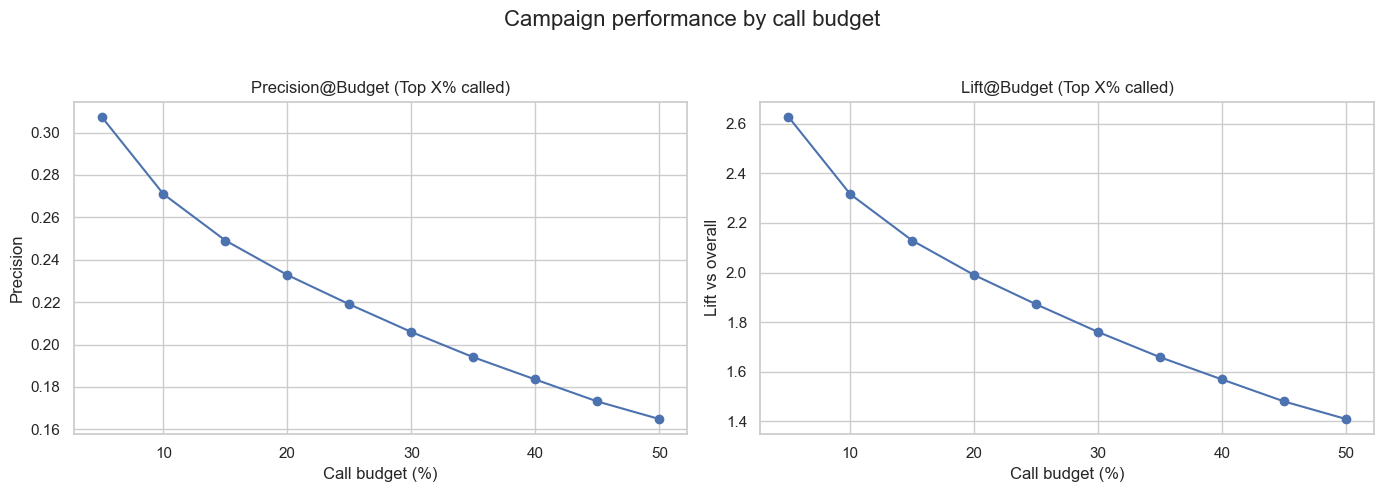

In [55]:
import matplotlib.pyplot as plt
import numpy as np

budgets = np.linspace(0.05, 0.50, 10)
prec_list, lift_list = [], []

p_all = df_scored["p_yes"].values
y_all = df_scored[TARGET].values

for b in budgets:
    prec_list.append(precision_at_k(y_all, p_all, b))
    lift_list.append(lift_at_k(y_all, p_all, b))

x = (budgets * 100).astype(int)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Precision@k
axes[0].plot(x, prec_list, marker="o")
axes[0].set_title("Precision@Budget (Top X% called)")
axes[0].set_xlabel("Call budget (%)")
axes[0].set_ylabel("Precision")

# Lift@k
axes[1].plot(x, lift_list, marker="o")
axes[1].set_title("Lift@Budget (Top X% called)")
axes[1].set_xlabel("Call budget (%)")
axes[1].set_ylabel("Lift vs overall")

fig.suptitle("Campaign performance by call budget", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [56]:
candidates

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y,poutcome_missing,target,pdays_contacted,has_previous_campaign,p_yes
66,60,retired,married,tertiary,no,100,no,no,NaN,5,may,528,1,-1,0,no_previous_campaign,no,1,0,0,0,0.752045
173,35,retired,single,primary,no,434,no,no,NaN,5,may,138,1,-1,0,no_previous_campaign,no,1,0,0,0,0.726108
265,30,student,single,tertiary,no,25,yes,no,NaN,5,may,89,2,-1,0,no_previous_campaign,no,1,0,0,0,0.669228
314,33,admin.,single,tertiary,no,193,no,no,NaN,5,may,132,2,-1,0,no_previous_campaign,no,1,0,0,0,0.709755
318,40,retired,single,primary,no,0,no,no,NaN,5,may,136,2,-1,0,no_previous_campaign,no,1,0,0,0,0.724752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45196,25,student,single,secondary,no,358,no,no,cellular,16,nov,330,1,-1,0,no_previous_campaign,yes,1,1,0,0,0.762793
45203,23,student,single,tertiary,no,113,no,no,cellular,17,nov,266,1,-1,0,no_previous_campaign,yes,1,1,0,0,0.800812
45204,73,retired,married,secondary,no,2850,no,no,cellular,17,nov,300,1,40,8,failure,yes,0,1,1,1,0.729913
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,no_previous_campaign,yes,1,1,0,0,0.709815


In [57]:
features = ['age','balance','p_yes','housing','pdays_contacted']
num_cols = ['age','balance','p_yes','pdays_contacted']
cat_cols = ['housing']

preprocess_seg = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("scaler", RobustScaler()),
        ]), num_cols),
        ("cat", Pipeline([
            ("ohe", OneHotEncoder(handle_unknown="ignore")),
        ]), cat_cols),
    ],
    remainder="drop",
)

X_seg = preprocess_seg.fit_transform(candidates[features])

In [58]:
candidates[features]

,age,balance,p_yes,housing,pdays_contacted
66,60,100,0.752045,no,0
173,35,434,0.726108,no,0
265,30,25,0.669228,yes,0
314,33,193,0.709755,no,0
318,40,0,0.724752,no,0
...,...,...,...,...,...
45196,25,358,0.762793,no,0
45203,23,113,0.800812,no,0
45204,73,2850,0.729913,no,1
45207,71,1729,0.709815,no,0


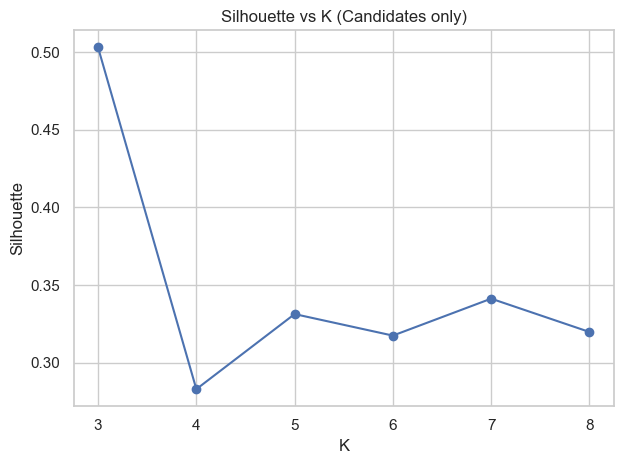

Best K: 3


segment
0    3721
1     656
2     145
Name: count, dtype: int64

In [59]:
from sklearn.cluster import MiniBatchKMeans

K_list = [3, 4, 5, 6, 7, 8]
sil = []
for k in K_list:
    km = MiniBatchKMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_seg)
    sil.append(silhouette_score(X_seg, labels))

plt.figure()
plt.plot(K_list, sil, marker="o")
plt.title("Silhouette vs K (Candidates only)")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

best_k = K_list[int(np.argmax(sil))]
print("Best K:", best_k)

K = best_k 
kmeans = MiniBatchKMeans(n_clusters=K, random_state=42, n_init="auto")
candidates["segment"] = kmeans.fit_predict(X_seg)

candidates["segment"].value_counts()


In [60]:
seg_summary = candidates.groupby("segment").agg(
    n=(TARGET, "size"),
    conversion=(TARGET, "mean"),
    avg_score=("p_yes", "mean"),
)

seg_summary["lift_vs_overall"] = seg_summary["conversion"] / BASE_CONV
seg_summary["lift_vs_candidates"] = seg_summary["conversion"] / candidates[TARGET].mean()
seg_summary = seg_summary.sort_values("lift_vs_overall", ascending=False)

seg_summary


,n,conversion,avg_score,lift_vs_overall,lift_vs_candidates
segment,,,,,
0,3721,0.274926,0.710647,2.350101,1.014870
1,656,0.266768,0.733899,2.280367,0.984756
2,145,0.186207,0.800008,1.591719,0.687369


/opt/anaconda3/envs/tf310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


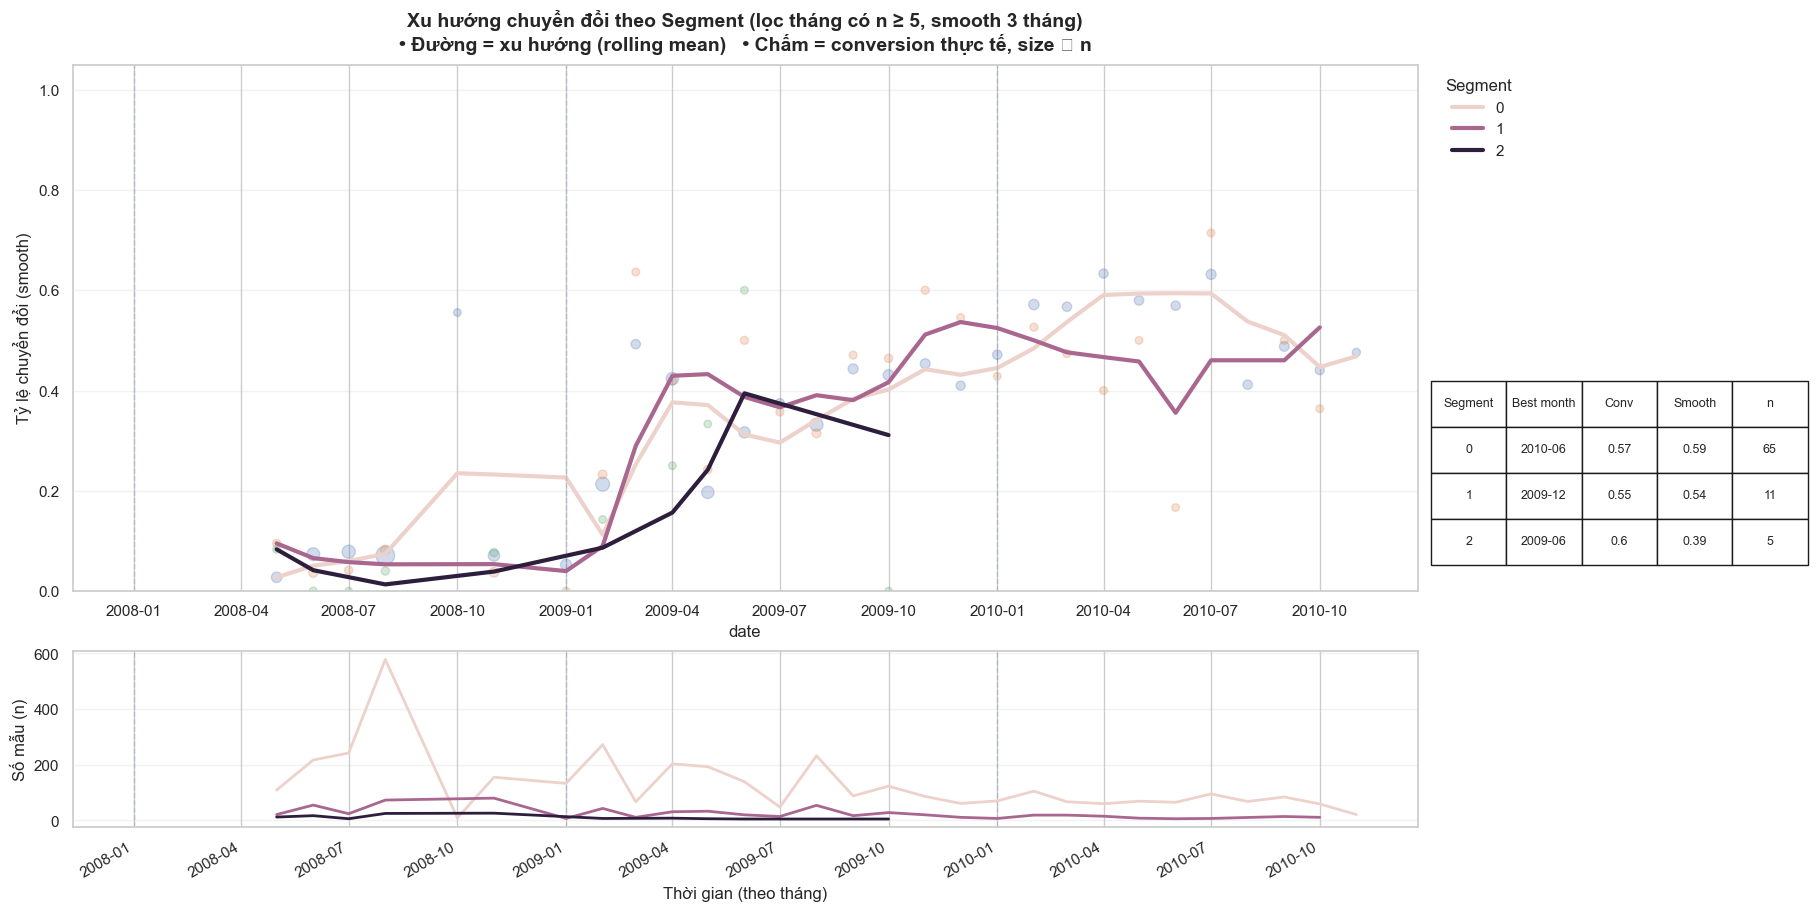

In [61]:

sns.set_theme(style="whitegrid")


months_order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
month_to_int = {m: i+1 for i, m in enumerate(months_order)}

def reconstruct_year(df):
    years = []
    current_year = 2008
    prev_month_idx = -1
    for month in df['month']:
        curr_month_idx = month_to_int[month.lower()]
        if curr_month_idx < prev_month_idx:
            current_year += 1
        years.append(current_year)
        prev_month_idx = curr_month_idx
    return years

candidates_ts = candidates.copy()
candidates_ts = candidates_ts.sort_index() 
candidates_ts['inferred_year'] = reconstruct_year(candidates_ts)
candidates_ts['month_idx'] = candidates_ts['month'].str.lower().map(month_to_int)

candidates_ts['date'] = pd.to_datetime(
    candidates_ts['inferred_year'].astype(str) + "-" +
    candidates_ts['month_idx'].astype(str).str.zfill(2) + "-01"
)

monthly_stats = (
    candidates_ts
    .groupby(['date','segment'])
    .agg(conversion=('target', 'mean'), n=('target', 'size'))
    .reset_index()
    .sort_values('date')
)

MIN_N = 5
df = monthly_stats[monthly_stats["n"] >= MIN_N].copy()

WINDOW = 3
df["conv_smooth"] = (
    df.sort_values("date")
      .groupby("segment")["conversion"]
      .transform(lambda s: s.rolling(WINDOW, min_periods=1).mean())
)

n_min, n_max = df["n"].min(), df["n"].max()
def size_map(n):
    if n_max == n_min:
        return 60
    return 30 + (n - n_min) * (180 - 30) / (n_max - n_min)

df["pt_size"] = df["n"].apply(size_map)

best = (
    df.loc[df.groupby("segment")["conv_smooth"].idxmax()]
      .sort_values("segment")
      .copy()
)
best["best_month"] = best["date"].dt.strftime("%Y-%m")
best["conv"] = best["conversion"].round(2)
best["conv_s"] = best["conv_smooth"].round(2)
fig = plt.figure(figsize=(18, 9), constrained_layout=True)
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)

sns.lineplot(data=df, x="date", y="conv_smooth", hue="segment", linewidth=3, ax=ax1)

# (2) Points sized by n (độ tin cậy) + (conversion gốc) để thấy dao động
for seg, g in df.groupby("segment"):
    ax1.scatter(g["date"], g["conversion"], s=g["pt_size"], alpha=0.25)

ax1.set_title(
    f"Xu hướng chuyển đổi theo Segment (lọc tháng có n ≥ {MIN_N}, smooth {WINDOW} tháng)\n"
    f"• Đường = xu hướng (rolling mean)   • Chấm = conversion thực tế, size ∝ n",
    fontsize=14, weight="bold", pad=10
)
ax1.set_ylabel("Tỷ lệ chuyển đổi (smooth)")
ax1.set_ylim(0, 1.05)
ax1.grid(True, axis="y", alpha=0.25)
monthly_stats = monthly_stats.sort_values(["segment","date"])
monthly_stats["conv_smooth"] = monthly_stats.groupby("segment")["conversion"]\
    .transform(lambda s: s.rolling(3, min_periods=1).mean())

plot_df = monthly_stats.copy()
plot_df["ok"] = plot_df["n"] >= MIN_N


ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax1.xaxis.set_minor_locator(mdates.MonthLocator())


years = df["date"].dt.year.unique()
for y in years:
    ax1.axvline(pd.Timestamp(f"{y}-01-01"), linestyle="--", linewidth=1, alpha=0.25)
    ax2.axvline(pd.Timestamp(f"{y}-01-01"), linestyle="--", linewidth=1, alpha=0.25)

# Legend gọn
ax1.legend(title="Segment", frameon=False, loc="upper left", bbox_to_anchor=(1.01, 1))

# (3) Volume chart (n)
sns.lineplot(data=df, x="date", y="n", hue="segment", linewidth=2, ax=ax2, legend=False)
ax2.set_ylabel("Số mẫu (n)")
ax2.set_xlabel("Thời gian (theo tháng)")
ax2.grid(True, axis="y", alpha=0.25)

plt.setp(ax2.get_xticklabels(), rotation=30, ha="right")

table_data = best[["segment", "best_month", "conv", "conv_s", "n"]].values.tolist()
col_labels = ["Segment", "Best month", "Conv", "Smooth", "n"]

tbl = ax1.table(
    cellText=table_data,
    colLabels=col_labels,
    colLoc="center",
    cellLoc="center",
    bbox=[1.01, 0.05, 0.28, 0.35]
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)

plt.show()


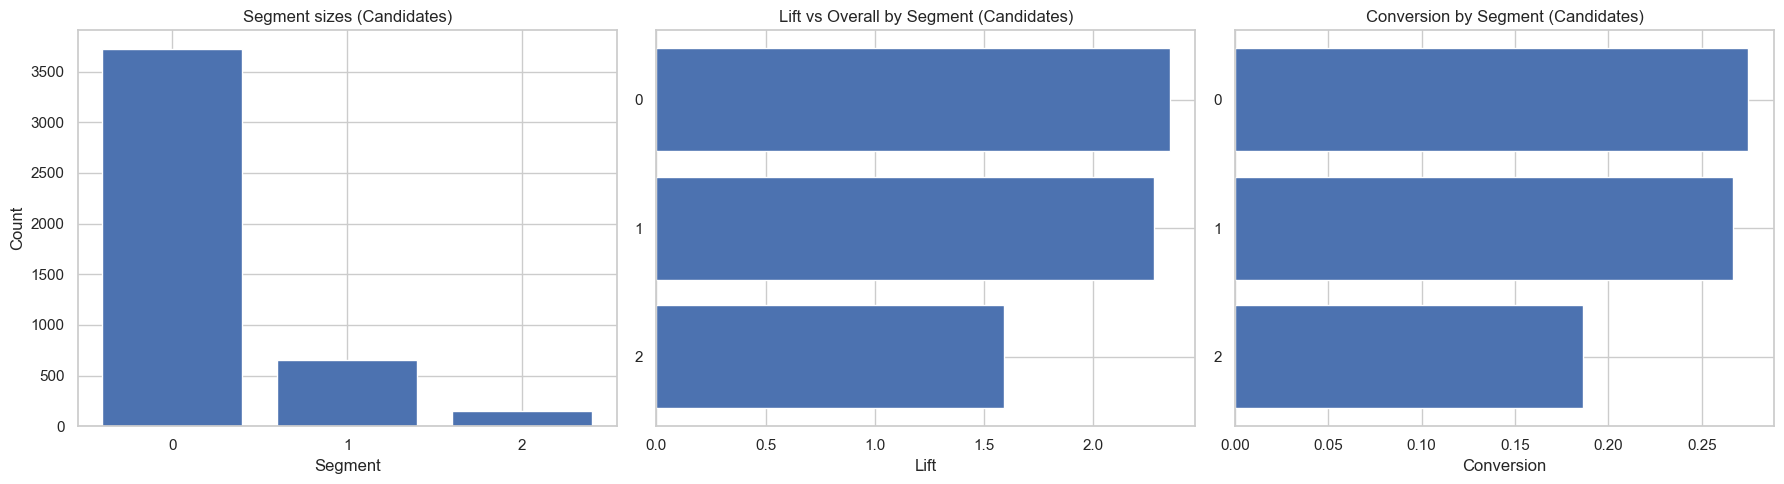

In [62]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(seg_summary.index.astype(str), seg_summary["n"])
axes[0].set_title("Segment sizes (Candidates)")
axes[0].set_xlabel("Segment")
axes[0].set_ylabel("Count")

tmp = seg_summary.sort_values("lift_vs_overall", ascending=True)


axes[1].barh(tmp.index.astype(str), tmp["lift_vs_overall"])
axes[1].set_title("Lift vs Overall by Segment (Candidates)")
axes[1].set_xlabel("Lift")

axes[2].barh(tmp.index.astype(str), tmp["conversion"])
axes[2].set_title("Conversion by Segment (Candidates)")
axes[2].set_xlabel("Conversion")

plt.tight_layout()
plt.show()

In [63]:
def top_share(series, top_n=3):
    vc = series.value_counts(normalize=True).head(top_n)
    return {str(k): float(v) for k, v in vc.items()}

def segment_profile(cand, seg_id):
    sub = cand[cand["segment"] == seg_id]
    out = {
        "segment": int(seg_id),
        "n": int(len(sub)),
        "conversion": float(sub[TARGET].mean()),
        "lift_vs_overall": float(sub[TARGET].mean() / BASE_CONV),
        "avg_score": float(sub["p_yes"].mean()),
        "age_median": float(sub["age"].median()) if "age" in sub else np.nan,
        "balance_median": float(sub["balance"].median()) if "balance" in sub else np.nan,
    }
    for c in ["job", "education", "marital", "default", "housing", "loan"]:
        if c in sub.columns:
            out[f"{c}_top"] = top_share(sub[c], top_n=3)
    return out

profiles = [segment_profile(candidates, seg) for seg in seg_summary.index]
profiles_df = pd.DataFrame(profiles)

profiles_df = profiles_df.sort_values("lift_vs_overall", ascending=False)
profiles_df

,segment,n,conversion,lift_vs_overall,avg_score,age_median,balance_median,job_top,education_top,marital_top,default_top,housing_top,loan_top
0,0,3721,0.274926,2.350101,0.710647,35.0,728.0,"{'retired': 0.32239849421887606, 'management':...","{'tertiary': 0.5711002585463947, 'secondary': ...","{'single': 0.6713249126578876, 'married': 0.24...","{'no': 0.999731255038968, 'yes': 0.00026874496...","{'no': 0.9787691480784735, 'yes': 0.0212308519...","{'no': 0.9914001612469766, 'yes': 0.0085998387..."
1,1,656,0.266768,2.280367,0.733899,43.0,8367.0,"{'management': 0.3563748079877112, 'retired': ...","{'tertiary': 0.5868167202572347, 'secondary': ...","{'single': 0.4725609756097561, 'married': 0.41...",{'no': 1.0},"{'no': 0.9801829268292683, 'yes': 0.0198170731...","{'no': 0.9984756097560976, 'yes': 0.0015243902..."
2,2,145,0.186207,1.591719,0.800008,48.0,26765.0,"{'management': 0.43448275862068964, 'retired':...","{'tertiary': 0.6197183098591549, 'secondary': ...","{'married': 0.593103448275862, 'single': 0.248...",{'no': 1.0},"{'no': 0.8344827586206897, 'yes': 0.1655172413...","{'no': 0.9724137931034482, 'yes': 0.0275862068..."


In [64]:
import numpy as np
import matplotlib.pyplot as plt

def plot_radar_on_ax(ax, radar_scaled, seg_id, title=None):
    labels = radar_scaled.columns.tolist()
    values = radar_scaled.loc[seg_id].values.tolist()
    values += values[:1]

    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.2)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title(title or f"Segment {seg_id}", y=1.12)

def plot_top_segments_radars_one_figure(
    radar_scaled,
    top_segments,
    seg_summary,
    ncols=4,
    figsize=(18, 6),
    suptitle="Top segments radar profiles",
):
    top_segments = list(top_segments)
    n = len(top_segments)
    ncols = min(ncols, n) if n > 0 else 1
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=figsize,
        subplot_kw=dict(polar=True)
    )
    
    if n == 1:
        axes = np.array([axes])
    axes = np.array(axes).reshape(-1)

    for ax, seg_id in zip(axes, top_segments):
        lift = seg_summary.loc[seg_id, "lift_vs_overall"] if seg_id in seg_summary.index else np.nan
        title = f"Segment {seg_id} (lift={lift:.2f}x)" if np.isfinite(lift) else f"Segment {seg_id}"
        plot_radar_on_ax(ax, radar_scaled, seg_id, title=title)

    # Xoá subplot dư nếu có
    for i in range(len(top_segments), len(axes)):
        fig.delaxes(axes[i])

    fig.suptitle(suptitle, fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()


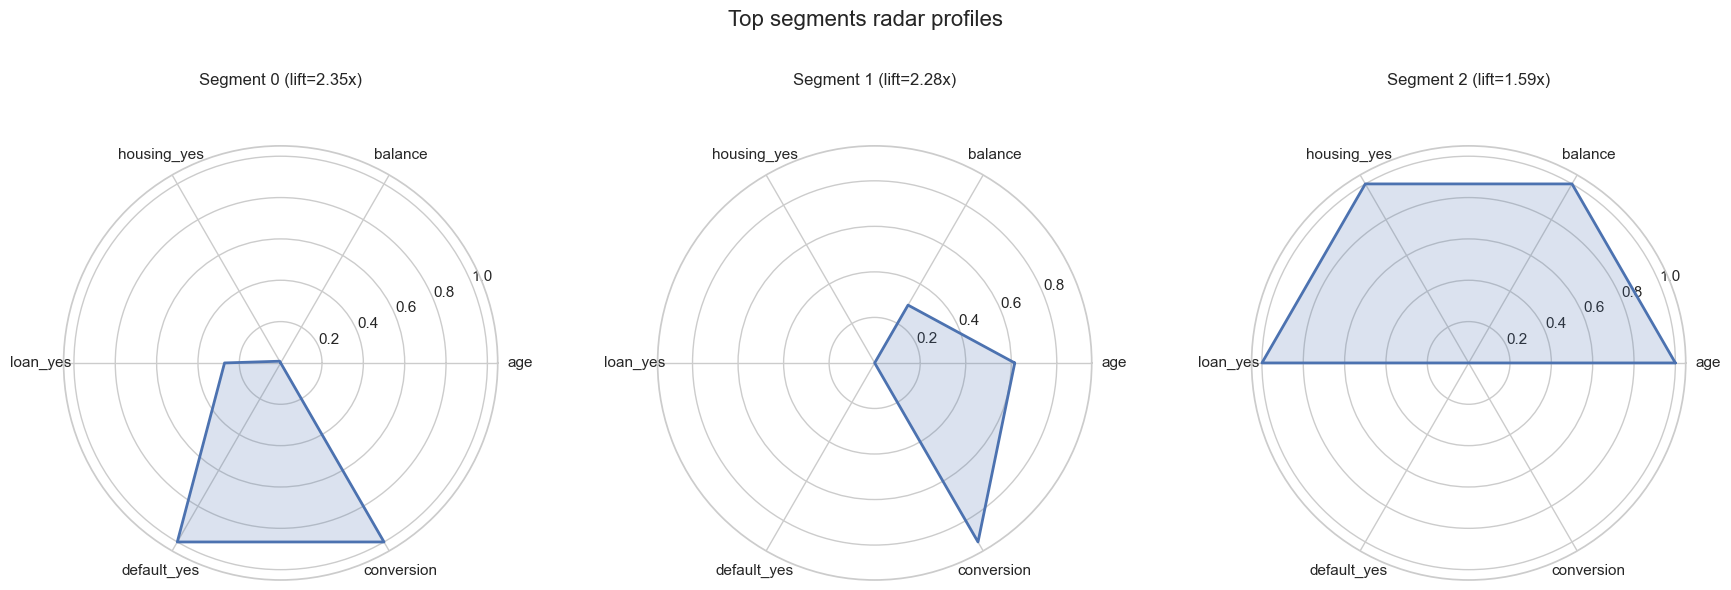

In [65]:
def radar_data_for_segment(cand: pd.DataFrame, seg_id: int, target_col: str) -> dict:
    sub = cand[cand["segment"] == seg_id].copy()

    vals = {}
    vals["age"] = float(sub["age"].median()) if "age" in sub else 0.0
    vals["balance"] = float(sub["balance"].median()) if "balance" in sub else 0.0

    # Tỷ lệ "yes" (nếu dữ liệu của bạn là 0/1 thì sửa điều kiện == 1)
    vals["housing_yes"] = float((sub["housing"] == "yes").mean()) if "housing" in sub else 0.0
    vals["loan_yes"] = float((sub["loan"] == "yes").mean()) if "loan" in sub else 0.0
    vals["default_yes"] = float((sub["default"] == "yes").mean()) if "default" in sub else 0.0

    # Conversion = mean của target (nếu target là yes/no thì map sang 1/0)
    if target_col in sub:
        s = sub[target_col]
        if s.dtype == object:
            s = s.astype(str).str.lower().map({"yes": 1, "no": 0})
        vals["conversion"] = float(pd.to_numeric(s, errors="coerce").fillna(0).mean())
    else:
        vals["conversion"] = 0.0

    return vals


def build_radar_scaled(
    candidates: pd.DataFrame,
    seg_summary: pd.DataFrame,
    target_col: str,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Return (radar_df, radar_scaled) where radar_scaled is min-max scaled across segments."""
    radar_rows = []
    for seg_id in seg_summary.index:
        row = radar_data_for_segment(candidates, int(seg_id), target_col=target_col)
        row["segment"] = int(seg_id)
        radar_rows.append(row)

    radar_df = pd.DataFrame(radar_rows).set_index("segment")

    # Min-max scale across segments (so dimensions comparable)
    denom = (radar_df.max() - radar_df.min()).replace(0, np.nan)
    radar_scaled = (radar_df - radar_df.min()) / (denom + 1e-9)
    radar_scaled = radar_scaled.fillna(0.0)

    return radar_df, radar_scaled


def _plot_radar_on_ax(ax, radar_scaled: pd.DataFrame, seg_id: int, title: str):
    labels = radar_scaled.columns.tolist()
    values = radar_scaled.loc[seg_id].values.tolist()
    values += values[:1]  # close the loop

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.2)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title(title, y=1.12)


def plot_segments_radars_one_figure(
    radar_scaled: pd.DataFrame,
    seg_summary: pd.DataFrame,
    segments: list[int],
    ncols: int = 3,
    figsize: tuple[int, int] = (18, 6),
    suptitle: str = "Radar profiles of selected segments",
    lift_col: str = "lift_vs_overall",
):
    segments = list(segments)
    n = len(segments)
    if n == 0:
        raise ValueError("segments is empty.")

    ncols = min(ncols, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=figsize,
        subplot_kw=dict(polar=True),
    )

    axes = np.array(axes).reshape(-1)  # flatten
    for ax, seg_id in zip(axes, segments):
        lift = np.nan
        if seg_id in seg_summary.index and lift_col in seg_summary.columns:
            lift = float(seg_summary.loc[seg_id, lift_col])

        title = f"Segment {seg_id} (lift={lift:.2f}x)" if np.isfinite(lift) else f"Segment {seg_id}"
        _plot_radar_on_ax(ax, radar_scaled, seg_id, title=title)

    # Delete extra axes
    for i in range(len(segments), len(axes)):
        fig.delaxes(axes[i])

    fig.suptitle(suptitle, fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()


# =========================
# 3) RUN: build + pick top segments + plot (ONE FIGURE)
# =========================
# Build radar matrices
radar_df, radar_scaled = build_radar_scaled(
    candidates=candidates,
    seg_summary=seg_summary,
    target_col=TARGET,   # ví dụ TARGET="target" hoặc "y"
)

# Pick top segments by lift (đổi head(3) thành số bạn muốn)
top_segments = (
    seg_summary.sort_values("lift_vs_overall", ascending=False)
    .head(4)
    .index.astype(int)
    .tolist()
)

# Plot on ONE figure
plot_segments_radars_one_figure(
    radar_scaled=radar_scaled,
    seg_summary=seg_summary,
    segments=top_segments,
    ncols=4,
    figsize=(18, 6),
    suptitle="Top segments radar profiles",
    lift_col="lift_vs_overall",
)


In [66]:
seg_summary

,n,conversion,avg_score,lift_vs_overall,lift_vs_candidates
segment,,,,,
0,3721,0.274926,0.710647,2.350101,1.014870
1,656,0.266768,0.733899,2.280367,0.984756
2,145,0.186207,0.800008,1.591719,0.687369


In [67]:
if all(c in candidates.columns for c in ["has_previous_campaign", "pdays_contacted"]):
    tmp = candidates.groupby("segment").agg(
        prev_campaign_rate=("has_previous_campaign", "mean"),
        pdays_contacted_median=("pdays_contacted", "median"),
        conversion=(TARGET, "mean"),
        n=(TARGET, "size")
    ).sort_values("conversion", ascending=False)

tmp

,prev_campaign_rate,pdays_contacted_median,conversion,n
segment,,,,
0,0.240795,0.0,0.274926,3721
1,0.266768,0.0,0.266768,656
2,0.179310,0.0,0.186207,145
